In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import cv2
import math
from PIL import Image
import glob
from zipfile import ZipFile
import os
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

2025-08-13 11:55:09.051430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755086109.313196      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755086109.395249      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
root_path = '/content/drive/MyDrive/Segmentation'
os.chdir(root_path)

In [ ]:
folders = [
    'Processed_train',
    'train',
    'GroundTruth',
    'Processed_GroundTruth',
    'validate',
    'Processed_validate',
    'GroundTruth_validate',
    'Processed_validate_GroundTruth'
]

for folder in folders:
    if not os.path.exists(folder):
        os.mkdir(folder)
        print(f"Created folder: {folder}")
    else:
        print(f"Folder already exists: {folder}")


####  Dataset folder info

*   Add the ISIC2018_Task1-2_Training_Input inside train folder
*   Add ISIC2018_Task1_Training_GroundTruth and ISIC2018_Task2_Training_GroundTruth_v3 in GroundTruth folder
*   Add ISIC2018_Task1-2_Validation_Input inside validate folder
*   Add ISIC2018_Task1_Validation_GroundTruth and ISIC2018_Task2_Validation_GroundTruth inside GroundTruth_validate folder

os.chdir(root_path+'/train/ISIC2018_Task1-2_Training_Input')

images = glob.glob('*.jpg')

In [ ]:
def bl_resize(original_img, new_h, new_w):
	#get dimensions of original image
	old_h, old_w, c = original_img.shape
	#create an array of the desired shape.
	resized = np.zeros((new_h, new_w, c))
	#Calculate horizontal and vertical scaling factor
	w_scale_factor = (old_w ) / (new_w ) if new_h != 0 else 0
	h_scale_factor = (old_h ) / (new_h ) if new_w != 0 else 0
	for i in range(new_h):
		for j in range(new_w):
			#map the coordinates back to the original image
			x = i * h_scale_factor
			y = j * w_scale_factor
			#calculate the coordinate values for 4 surrounding pixels.
			x_floor = math.floor(x)
			x_ceil = min( old_h - 1, math.ceil(x))
			y_floor = math.floor(y)
			y_ceil = min(old_w - 1, math.ceil(y))

			if (x_ceil == x_floor) and (y_ceil == y_floor):
				q = original_img[int(x), int(y), :]
			elif (x_ceil == x_floor):
				q1 = original_img[int(x), int(y_floor), :]
				q2 = original_img[int(x), int(y_ceil), :]
				q = q1 * (y_ceil - y) + q2 * (y - y_floor)
			elif (y_ceil == y_floor):
				q1 = original_img[int(x_floor), int(y), :]
				q2 = original_img[int(x_ceil), int(y), :]
				q = (q1 * (x_ceil - x)) + (q2	 * (x - x_floor))
			else:
				v1 = original_img[x_floor, y_floor, :]
				v2 = original_img[x_ceil, y_floor, :]
				v3 = original_img[x_floor, y_ceil, :]
				v4 = original_img[x_ceil, y_ceil, :]

				q1 = v1 * (x_ceil - x) + v2 * (x - x_floor)
				q2 = v3 * (x_ceil - x) + v4 * (x - x_floor)
				q = q1 * (y_ceil - y) + q2 * (y - y_floor)

			resized[i,j,:] = q
	return resized.astype(np.uint8)

def apply_clahe(red_img_arr):
  #1
  image_lab = cv2.cvtColor(red_img_arr, cv2.COLOR_BGR2LAB)
  #2
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  colorimage_l = clahe.apply(image_lab[:,:,0])
  #3
  colorimage_clahe = np.stack((colorimage_l,image_lab[:,:,1],image_lab[:,:,2]), axis=2)
  #4
  image_rgb = cv2.cvtColor(colorimage_clahe, cv2.COLOR_LAB2BGR)
  pilImage = Image.fromarray(image_rgb)
  return image_rgb

# Convert the original image to grayscale
def Hair_removal(image_clahe):
  grayScale = cv2.cvtColor( image_clahe, cv2.COLOR_RGB2GRAY )

  # Kernel for the morphological filtering
  kernel = cv2.getStructuringElement(1,(17,17))

  # Performing the blackHat filtering on the grayscale image to find the
  # hair countours
  blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
  # intensify the hair countours in preparation for the inpainting
  # algorithm
  ret,thresh2 = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
  # inpaint the original image depending on the mask
  dst = cv2.inpaint(image_clahe,thresh2,1,cv2.INPAINT_TELEA)

  FinalImage = Image.fromarray(dst)
  return FinalImage

In [ ]:
#Pre-Processing all the input training images
for i in images:
    filename = os.path.basename(i)
    save_path = os.path.join(root_path, 'Processed_train', filename)

    # Skip processing if file already exists
    if os.path.exists(save_path):
        print(f"File already exists, skipped: {save_path}")
        continue

    # Only process if file doesn't exist
    img = Image.open(i)
    np_img = np.array(img)
    width, height = img.width, img.height

    red_wid = int(0.25 * width)
    red_height = int(0.25 * height)

    red_img_arr = bl_resize(np_img, 256, 384)
    image_clahe = apply_clahe(red_img_arr)
    Pro_img = Hair_removal(image_clahe)

    Pro_img.save(save_path)
    print(f"Saved: {save_path}")

In [ ]:
#Resizing Training masks
os.chdir(root_path+'/GroundTruth/ISIC2018_Task1_Training_GroundTruth')

masks = glob.glob("*.png")

In [ ]:
from PIL import Image
import os

for i in masks:
    print(i)
    filename = os.path.basename(i)
    save_filename = filename[:-17] + '.png'  # Use PNG for lossless format
    save_path = os.path.join(root_path, 'Processed_GroundTruth', save_filename)

    if os.path.exists(save_path):
        print(f"File already exists, skipped: {save_path}")
        continue

    # Open, convert to grayscale, and resize with NEAREST to preserve labels
    img = Image.open(i).convert('L')
    resized_mask = img.resize((256, 384), resample=Image.NEAREST)

    # Binarize mask
    binary_mask = resized_mask.point(lambda p: 255 if p > 128 else 0)

    binary_mask.save(save_path)
    print(f"Saved: {save_path}")



In [ ]:
#Pre-Processing all the input validation images
os.chdir(root_path+'/validate/ISIC2018_Task1-2_Validation_Input')

validate = glob.glob("*.jpg")

In [ ]:
for i in validate:
    filename = os.path.basename(i)
    save_path = os.path.join(root_path, 'Processed_validate', filename)

    # Check if file already exists to skip processing
    if os.path.exists(save_path):
        print(f"File already exists, skipped: {save_path}")
        continue

    # Load and preprocess only if not already processed
    img = Image.open(i)
    np_img = np.array(img)

    red_img_arr = bl_resize(np_img, 256, 384)
    image_clahe = apply_clahe(red_img_arr)
    Pro_img = Hair_removal(image_clahe)

    Pro_img.save(save_path)
    print(f"Saved: {save_path}")


In [ ]:
#Resizing validation masks
val_masks = glob.glob("*.png")


from PIL import Image
import os

for i in val_masks:
    print(i)
    filename = os.path.basename(i)
    save_filename = filename[:-17] + '.png'  # Use PNG for lossless format
    save_path = os.path.join(root_path, 'Processed_validate_GroundTruth', save_filename)

    if os.path.exists(save_path):
        print(f"File already exists, skipped: {save_path}")
        continue

    # Open, convert to grayscale, and resize with NEAREST to preserve labels
    img = Image.open(i).convert('L')
    resized_mask = img.resize((256, 384), resample=Image.NEAREST)

    # Binarize mask
    binary_mask = resized_mask.point(lambda p: 255 if p > 128 else 0)

    binary_mask.save(save_path)
    print(f"Saved: {save_path}")


In [7]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT, IMG_WIDTH = 256, 384
batch_size = 32
seed = 24

# Optional: define augmentation
img_data_gen_args = dict(horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

image_datagen = ImageDataGenerator(**img_data_gen_args)
mask_datagen = ImageDataGenerator(**img_data_gen_args)

class CustomDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=batch_size, augment=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.augment = augment
        self.indices = np.arange(len(self.image_filenames))

    def __len__(self):
        return len(self.image_filenames) // self.batch_size

    def __getitem__(self, idx):
        batch_images = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_masks = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        imgs, masks = [], []
        for img_name, mask_name in zip(batch_images, batch_masks):
            img_path = os.path.join(self.image_dir, img_name)
            mask_path = os.path.join(self.mask_dir, mask_name)

            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img / 255.0

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)  # for model compatibility

            imgs.append(img)
            masks.append(mask)

        imgs = np.array(imgs, dtype=np.float32)
        masks = np.array(masks, dtype=np.float32)

        if self.augment:
            seed = np.random.randint(10000)
            imgs = next(image_datagen.flow(imgs, batch_size=self.batch_size, shuffle=False, seed=seed))
            masks = next(mask_datagen.flow(masks, batch_size=self.batch_size, shuffle=False, seed=seed))

        return imgs, masks



In [8]:
# root_path = '/kaggle/input/segmentation-train'
# root_path_val = '/kaggle/input/segmentation-dataset'
train_img_path = '/kaggle/input/segmentation-train/Processed_train/Processed_train'
train_mask_path = '/kaggle/input/segmentation-train/Processed_GroundTruth/Processed_GroundTruth'
val_img_path = '/kaggle/input/segmentation-dataset/Processed_validate/Processed_validate'
val_mask_path = '/kaggle/input/segmentation-dataset/Processed_validate_GroundTruth/Processed_validate_GroundTruth'

train_gen = CustomDataGenerator(train_img_path, train_mask_path, batch_size=batch_size, augment=True)
val_gen = CustomDataGenerator(val_img_path, val_mask_path, batch_size=batch_size, augment=False)

# For preview
x_batch, y_batch = train_gen[0]
x_val, y_val = val_gen[0]
steps_per_epoch = len(train_gen)
val_steps = len(val_gen)

In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers with optional batch normalization"""
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(x)  # ✅ use x
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


In [10]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [11]:
from keras.layers import Input
from keras.optimizers import Adam
IMG_HEIGHT = 256  # or 384 depending on your resized shape
IMG_WIDTH = 384   # adjust as per your data

input_img = Input((IMG_HEIGHT,IMG_WIDTH, 3))
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

2025-08-13 11:56:42.656640: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
import os

checkpoint_dir = "/kaggle/working/checkpoints_unet"
os.makedirs(checkpoint_dir, exist_ok=True)

weights_path = os.path.join(checkpoint_dir, "unet_epoch_{epoch:02d}.h5")
last_epoch_path = os.path.join(checkpoint_dir, "last_epoch.txt")


In [4]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model

# ----- Default values -----
initial_epoch = 0
latest_weights = None

# ----- Resume training if checkpoint exists -----
if os.path.exists(last_epoch_path):
    with open(last_epoch_path, "r") as f:
        initial_epoch = int(f.read().strip()) + 1
        latest_weights = os.path.join(checkpoint_dir, f"unet_epoch_{initial_epoch-1:02d}.weights.h5")
        print(f"Resuming from epoch {initial_epoch}, loading weights from {latest_weights}")

    if os.path.exists(latest_weights):
        model.load_weights(latest_weights)

# ----- Callbacks -----
early_stopping = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1)
checkpoint_callback = ModelCheckpoint(
    filepath=weights_path,
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)
save_epoch_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: open(last_epoch_path, "w").write(str(epoch))
)

callbacks = [early_stopping, reduce_lr, checkpoint_callback, save_epoch_callback]


In [ ]:
results = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    initial_epoch=initial_epoch,  # resume from this epoch
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    verbose=1
)


In [ ]:
model.save('Segmentation_model_Unet.h5')

In [ ]:
model.load_weights("/kaggle/working/Segmentation_model_Unet.h5")

In [15]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

IMG_HEIGHT = 256
IMG_WIDTH = 384
IMG_CHANNELS = 3

class ValidationDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=8):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_ids = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_ids))

    def __getitem__(self, index):
        batch_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]

        X = np.zeros((len(batch_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
        y = np.zeros((len(batch_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

        for i, img_id in enumerate(batch_ids):
            # Load image
            img_path = os.path.join(self.image_dir, img_id)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            X[i] = img / 255.0  # Normalize

            # Load corresponding mask
            mask_id = img_id.replace(".jpg", ".png")
            mask_path = os.path.join(self.mask_dir, mask_id)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
            _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
            y[i, ..., 0] = mask / 255.0  # Normalize mask to 0/1

        return X, y


In [16]:
val_gen = ValidationDataGenerator(val_img_path, val_mask_path, batch_size=4)

# Optional: evaluate model
results = model.evaluate(val_gen)
print(f"Validation Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 519ms/step - accuracy: 0.9285 - loss: 0.1783
Validation Loss: 0.1818, Accuracy: 0.9268


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


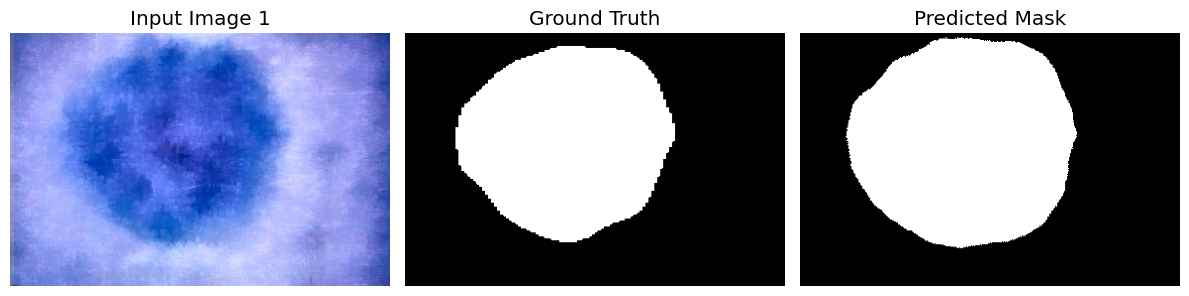

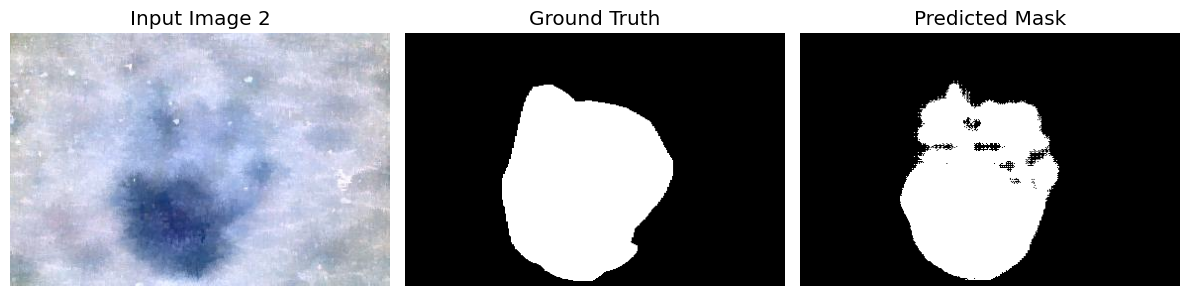

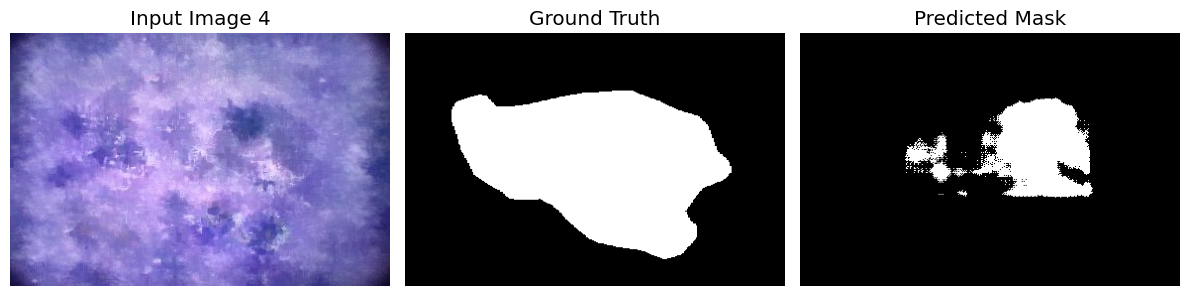

In [17]:
import matplotlib.pyplot as plt

# Predict on first batch from validation generator
X_val, Y_true = val_gen[0]  # Get first batch
Y_pred = model.predict(X_val)

# Threshold predicted masks
Y_pred_binary = (Y_pred > 0.5).astype(np.uint8)

# Plot 10 samples
num_samples = min(10, len(X_val))
for i in range(num_samples):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(X_val[i])
    ax[0].set_title(f"Input Image {i+1}")
    ax[0].axis('off')

    ax[1].imshow(Y_true[i].squeeze(), cmap='gray')
    ax[1].set_title("Ground Truth")
    ax[1].axis('off')

    ax[2].imshow(Y_pred_binary[i].squeeze(), cmap='gray')
    ax[2].set_title("Predicted Mask")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()


In [19]:
import numpy as np

def compute_metrics(y_true, y_pred):
    """Computes evaluation metrics for binary masks."""
    assert y_true.shape == y_pred.shape, "Shape mismatch!"

    metrics = {
        'Sensitivity (Recall)': [],
        'Specificity': [],
        'Precision': [],
        'F1 Score': [],
        'Global Accuracy': []
    }

    for i in range(y_true.shape[0]):
        gt = y_true[i].astype(np.uint8).flatten()
        pred = y_pred[i].astype(np.uint8).flatten()

        TP = np.sum((gt == 1) & (pred == 1))
        TN = np.sum((gt == 0) & (pred == 0))
        FP = np.sum((gt == 0) & (pred == 1))
        FN = np.sum((gt == 1) & (pred == 0))

        sensitivity = TP / (TP + FN + 1e-6)
        specificity = TN / (TN + FP + 1e-6)
        precision   = TP / (TP + FP + 1e-6)
        f1_score    = 2 * precision * sensitivity / (precision + sensitivity + 1e-6)
        accuracy    = (TP + TN) / (TP + TN + FP + FN + 1e-6)

        metrics['Sensitivity (Recall)'].append(sensitivity)
        metrics['Specificity'].append(specificity)
        metrics['Precision'].append(precision)
        metrics['F1 Score'].append(f1_score)
        metrics['Global Accuracy'].append(accuracy)

    # Compute average of all metrics
    final_metrics = {k: np.mean(v) for k, v in metrics.items()}
    return final_metrics

# --- Usage ---

# Ensure shape is (samples, 256, 384)
if Y_true.shape[-1] == 1:
    Y_true = Y_true.squeeze(-1)
if Y_pred_binary.shape[-1] == 1:
    Y_pred_binary = Y_pred_binary.squeeze(-1)

# Compute and print metrics
final_results = compute_metrics(Y_true, Y_pred_binary)

print("\n--- Final Evaluation Metrics ---")
for metric, value in final_results.items():
    print(f"{metric}: {value:.4f}")



--- Final Evaluation Metrics ---
Sensitivity (Recall): 0.7495
Specificity: 0.9748
Precision: 0.9519
F1 Score: 0.7995
Global Accuracy: 0.9047


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set path and list of images
val_path = '/kaggle/input/classification-skin/content/drive/MyDrive/skin_classification/Classification_Processed/Processed_train'
val_images = sorted(os.listdir(val_path))[30:40]  # take first 10 images

# Predict and visualize
for fname in val_images:
    img_path = os.path.join(val_path, fname)

    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img_input = img / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    # Predict mask
    pred_mask = model.predict(img_input)[0, :, :, 0]  # shape: (H, W)

    # Threshold for binary mask
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

    # Plot image and predicted mask
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask_bin, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Predicting For 2019 Dataset

In [1]:
from tensorflow.keras.models import load_model
model=load_model('/kaggle/input/segmentation/other/final_model/1/Segmentation_model_Unet.h5')

2025-08-07 14:54:27.484971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754578467.682886      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754578467.746011      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1754578480.173774      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
import os
import glob
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

# Set input and output folders
input_folder = '/kaggle/input/classification-skin/content/drive/MyDrive/skin_classification/Classification_Processed/Processed_train'
output_mask_folder = '/kaggle/working/Classification_Train/Masks'
output_region_folder = '/kaggle/working/Classification_Train/Regions'
# Create output directories
os.makedirs(output_mask_folder, exist_ok=True)
os.makedirs(output_region_folder, exist_ok=True)

# Get image paths
test_images = sorted(glob.glob(os.path.join(input_folder, '*.jpg')))

# Model input size
H, W = 256, 384

# For plotting/display
sample_imgs, sample_masks, sample_regions = [], [], []

In [5]:
import os
import cv2
import numpy as np

batch_size = 500
sample_imgs, sample_masks, sample_regions = [], [], []  # Initialize lists

for i in range(0, len(test_images), batch_size):
    batch_files = test_images[i:i + batch_size]
    Data_batch = []

    for file in batch_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (384, 256))
        Data_batch.append(img)

    Data_batch = np.array(Data_batch, dtype=np.float32) / 255.0
    predictions = model.predict(Data_batch, batch_size=16, verbose=0)
    predictions = (predictions > 0.5).astype(np.uint8) * 255
    
    for j, file in enumerate(batch_files):
        filename = os.path.basename(file)
        original_img = Data_batch[j]  # [0,1] range
        original_resized = cv2.resize(original_img, (256, 256))
    
        # Save mask
        mask = cv2.resize(np.squeeze(predictions[j]), (256, 256))
        cv2.imwrite(os.path.join(output_mask_folder, filename), mask)
        
        # Save ROI
        mask_3ch = np.stack([mask] * 3, axis=-1)
        ROI = original_resized.copy()
        ROI[mask_3ch == 0] = 1.0  # Background = white
        ROI_to_save = (ROI * 255).astype(np.uint8)
        ROI_to_save = cv2.cvtColor(ROI_to_save, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(output_region_folder, filename), ROI_to_save)
        
        # Store samples (up to 25)
        if len(sample_imgs) < 25:
            sample_imgs.append(original_resized)
            sample_masks.append(mask)
            sample_regions.append(ROI)

    print(f"Processed and saved {len(batch_files)} images from index {i} to {i + len(batch_files) - 1}")

print("All masks and segmented regions saved.")
print(f"Total saved masks: {len(os.listdir(output_mask_folder))}")
print(f"Total saved ROIs: {len(os.listdir(output_region_folder))}")

Processed and saved 500 images from index 0 to 499
Processed and saved 500 images from index 500 to 999
Processed and saved 500 images from index 1000 to 1499
Processed and saved 500 images from index 1500 to 1999
Processed and saved 500 images from index 2000 to 2499
Processed and saved 500 images from index 2500 to 2999
Processed and saved 500 images from index 3000 to 3499
Processed and saved 500 images from index 3500 to 3999
Processed and saved 500 images from index 4000 to 4499
Processed and saved 500 images from index 4500 to 4999
Processed and saved 500 images from index 5000 to 5499
Processed and saved 500 images from index 5500 to 5999
Processed and saved 500 images from index 6000 to 6499
Processed and saved 500 images from index 6500 to 6999
Processed and saved 500 images from index 7000 to 7499
Processed and saved 500 images from index 7500 to 7999
Processed and saved 500 images from index 8000 to 8499
Processed and saved 500 images from index 8500 to 8999
Processed and sa

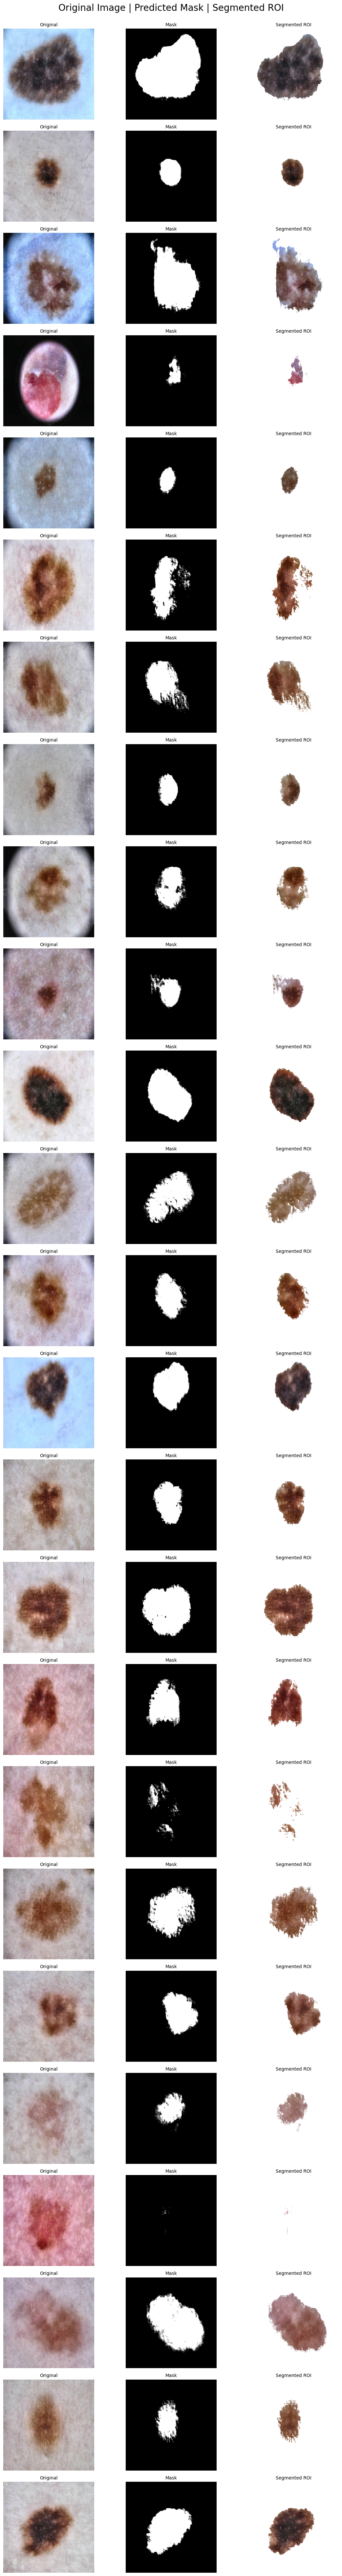

In [6]:
fig, ax = plt.subplots(25, 3, figsize=(12, 80))
fig.suptitle('Original Image | Predicted Mask | Segmented ROI', fontsize=20)

for i in range(25):
    ax[i, 0].imshow(sample_imgs[i])
    ax[i, 0].axis('off')
    ax[i, 0].set_title('Original', fontsize=10)

    ax[i, 1].imshow(sample_masks[i], cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].set_title('Mask', fontsize=10)

    ax[i, 2].imshow(sample_regions[i])
    ax[i, 2].axis('off')
    ax[i, 2].set_title('Segmented ROI', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
